In [2]:
pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00


In [4]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np
import torch.nn as nn
#import torch.optim as Optimizer

class diffgrad(Optimizer):
    r"""Implements diffGrad algorithm. It is modified from the pytorch implementation of Adam.
    It has been proposed in `diffGrad: An Optimization Method for Convolutional Neural Networks`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _diffGrad: An Optimization Method for Convolutional Neural Networks:
        https://arxiv.org/abs/1909.11015
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(diffgrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(diffgrad, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('diffGrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq, previous_grad= state['exp_avg'], state['exp_avg_sq'], state['previous_grad']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # compute diffgrad coefficient (dfc)
                diff = abs(previous_grad - grad)
                dfc = 1. / (1. + torch.exp(-diff))
                state['previous_grad'] = grad # used in paper but has the bug that previous grad is overwritten with grad and diff becomes always zero. Fixed in the next line.

		# update momentum with dfc
                exp_avg1 = exp_avg * dfc

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg1, denom)

        return loss

In [5]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np
import torch.nn as nn


class tanangulargrad(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(tanangulargrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(tanangulargrad, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'tanangulargrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(p.data)
                    # temporary minimum value for comparison
                    state['min'] = torch.zeros_like(p.data)
                    # temporary difference between gradients for comparison
                    state['diff'] = torch.zeros_like(p.data)
                    # final tan value to be used
                    state['final_tan_theta'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq, previous_grad, min, diff, final_tan_theta = state['exp_avg'], state['exp_avg_sq'], \
                                                                                 state['previous_grad'], state['min'], \
                                                                                 state['diff'], state['final_tan_theta']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                tan_theta = abs((previous_grad - grad) / (1 + previous_grad * grad))

                angle = torch.atan(tan_theta) * (180 / 3.141592653589793238)
                ans = torch.gt(angle, min)
                ans1, count = torch.unique(ans, return_counts=True)

                try:
                    if (count[1] < count[0]):
                        min = angle
                        diff = abs(previous_grad - grad)
                        final_tan_theta = tan_theta.clone()
                except:
                    if (ans1[0].item() == False):
                        min = angle
                        diff = abs(previous_grad - grad)
                        final_tan_theta = tan_theta.clone()

                angular_coeff = torch.tanh(abs(final_tan_theta)) * 0.5 +0.5    # Calculating Angular coefficient

                state['previous_grad'] = grad.clone()
                state['min'] = min.clone()
                state['diff'] = diff.clone()
                state['final_tan_theta'] = final_tan_theta.clone()

                # update momentum with angular_coeff
                exp_avg1 = exp_avg * angular_coeff

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg1, denom)

        return loss

In [3]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np
import torch.nn as nn
#import torch.optim as Optimizer

class sqFm(Optimizer):


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(sqFm, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(sqFm, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('sqFm does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq, previous_grad= state['exp_avg'], state['exp_avg_sq'], state['previous_grad']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta1, exp_avg, exp_avg)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']


                diff = abs(grad)
                dfc = 1. / (1. + torch.exp(grad))
                state['previous_grad'] = grad
                exp_avg1 = exp_avg * dfc

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg1, denom)

        return loss

  1%|          | 2/200 [00:00<00:15, 12.85trial/s, best loss: 5.188794863810955]

<ipython-input-17-c3cca3cecd3f>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


100%|██████████| 200/200 [00:17<00:00, 11.66trial/s, best loss: 0.1444124287369064]
0.49545079892596344 <class '__main__.sqFm'>


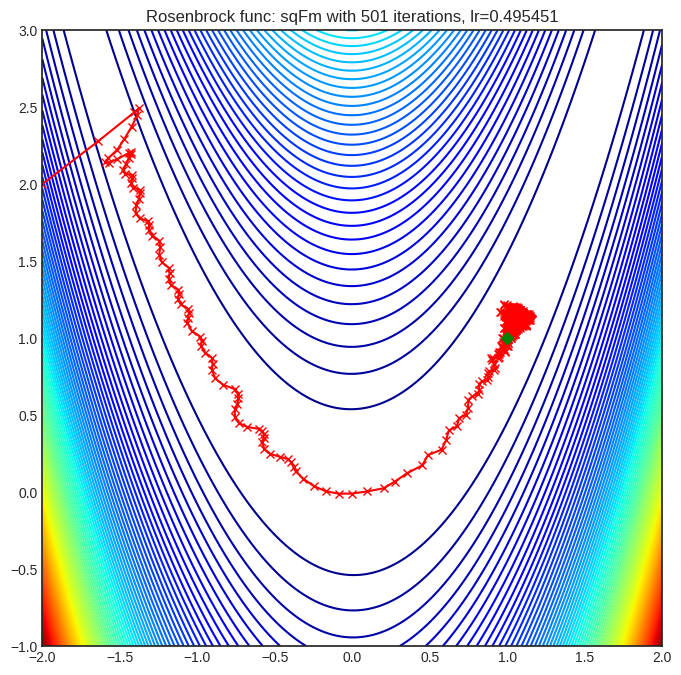

In [17]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from hyperopt import fmin, hp, tpe
#import torch_optimizer as optimizer
#import torch_optimizer as optim

plt.style.use('seaborn-white')


def rosenbrock(tensor):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    x, y = tensor
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


def rastrigin(tensor, lib=torch):
    # https://en.wikipedia.org/wiki/Test_functions_for_optimization
    x, y = tensor
    A = 10
    f = (
        A * 2
        + (x ** 2 - A * lib.cos(x * math.pi * 2))
        + (y ** 2 - A * lib.cos(y * math.pi * 2))
    )
    return f


def execute_steps(
    func, initial_state, optimizer_class, optimizer_config, num_iter=500
):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter + 1))
    steps[:, 0] = np.array(initial_state)
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        f = func(x)
        f.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
    return steps


def objective_rastrigin(params):
    lr = params['lr']
    optimizer_class = params['optimizer_class']
    initial_state = (-2.0, 3.5)
    minimum = (0, 0)
    optimizer_config = dict(lr=lr)
    num_iter = 100
    steps = execute_steps(
        rastrigin, initial_state, optimizer_class, optimizer_config, num_iter
    )
    return (steps[0][-1] - minimum[0]) ** 2 + (steps[1][-1] - minimum[1]) ** 2


def objective_rosenbrok(params):
    lr = params['lr']
    optimizer_class = params['optimizer_class']
    minimum = (1.0, 1.0)
    initial_state = (-2.0, 2.0)
    optimizer_config = dict(lr=lr)
    num_iter = 100
    steps = execute_steps(
        rosenbrock, initial_state, optimizer_class, optimizer_config, num_iter
    )
    return (steps[0][-1] - minimum[0]) ** 2 + (steps[1][-1] - minimum[1]) ** 2


def plot_rastrigin(grad_iter, optimizer_name, lr):
    x = np.linspace(-4.5, 4.5, 250)
    y = np.linspace(-4.5, 4.5, 250)
    minimum = (0, 0)

    X, Y = np.meshgrid(x, y)
    Z = rastrigin([X, Y], lib=np)

    iter_x, iter_y = grad_iter[0, :], grad_iter[1, :]

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 1, 1)
    ax.contour(X, Y, Z, 20, cmap='jet')
    ax.plot(iter_x, iter_y, color='r', marker='x')
    ax.set_title(
        'Rastrigin func: {} with '
        '{} iterations, lr={:.6}'.format(optimizer_name, len(iter_x), lr)
    )
    plt.plot(*minimum, 'gD')
    plt.plot(iter_x[-1], iter_y[-1], 'rD')
    #plt.savefig('docs/rastrigin_{}.png'.format(optimizer_name))


def plot_rosenbrok(grad_iter, optimizer_name, lr):
    x = np.linspace(-2, 2, 250)
    y = np.linspace(-1, 3, 250)
    minimum = (1.0, 1.0)

    X, Y = np.meshgrid(x, y)
    Z = rosenbrock([X, Y])

    iter_x, iter_y = grad_iter[0, :], grad_iter[1, :]

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 1, 1)
    ax.contour(X, Y, Z, 90, cmap='jet')
    ax.plot(iter_x, iter_y, color='r', marker='x')

    ax.set_title(
        'Rosenbrock func: {} with {} '
        'iterations, lr={:.6}'.format(optimizer_name, len(iter_x), lr)
    )
    plt.plot(*minimum, 'gD')
    plt.plot(iter_x[-1], iter_y[-1], 'rD')
    #plt.savefig('docs/rosenbrock_{}.png'.format(optimizer_name))


def execute_experiments(
    optimizers, objective, func, plot_func, initial_state, seed=1
):
    seed = seed
    for item in optimizers:
        optimizer_class, lr_low, lr_hi = item
        space = {
            'optimizer_class': hp.choice('optimizer_class', [optimizer_class]),
            'lr': hp.loguniform('lr', lr_low, lr_hi),
        }
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            rstate=np.random.default_rng(seed),
        )
        print(best['lr'], optimizer_class)

        steps = execute_steps(
            func,
            initial_state,
            optimizer_class,
            {'lr': best['lr']},
            num_iter=500,
        )
        plot_func(steps, optimizer_class.__name__, best['lr'])



if __name__ == '__main__':
    # python examples/viz_optimizers.py

    # Each optimizer has tweaked search space to produce better plots and
    # help to converge on better lr faster.
    optimizers = [
        # baselines

        #(tanangulargrad, -6, -0.2),

        #(Padam, -6, -0.2),


        (sqFm, -8, -0.7)

    ]


    execute_experiments(
        optimizers,
        objective_rosenbrok,
        rosenbrock,
        plot_rosenbrok,
        (-2.0, 2.0),
    )


